<a href="https://colab.research.google.com/github/IdanC1s2/RL_Beginner2Master/blob/main/Section_3_value_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align:center">
    <h1>
        Value Iteration
    </h1>
</div>
<br>

<div style="text-align:center">
    <p>
        In this notebook we are going to look at a dynamic programming algorithm called value iteration. In it, we will sweep the state space and update all the V(s) values.
    </p>
</div>

In [2]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import the necessary software libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Initialize the environment

In [4]:
env = Maze()

## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [29]:
def rand_policy(state):
  p_vec = np.array([0.25]*4)
  return p_vec

#### Test the policy starting with state (0, 0)

In [30]:
env.reset()
policy = rand_policy
test_agent(env, policy)  # Termination might take a while

#### Plot the policy

TypeError: 'int' object does not support item assignment

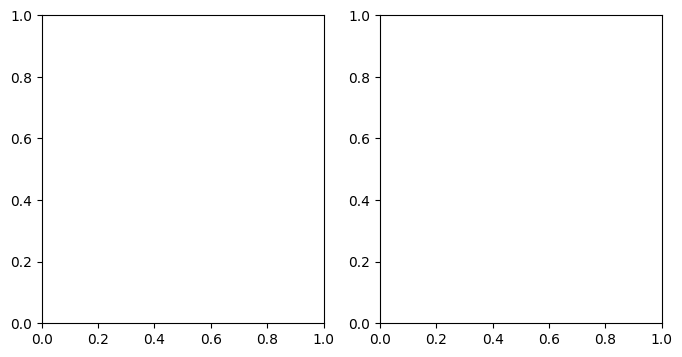

In [20]:
frame = env.render(mode='rgb_array')
probs_or_qvals = rand_policy((0,0))

# probs_or_qvals - matrix whose each row contains the probabilities for all actions
n_acts = len(env.action_space.action_meanings)
n_states = np.prod(env.observation_space.nvec)

probs_or_qvals = np.zeros([n_states,n_acts])
for i in range(size):
  for j in range(size):
    state = (i,j)
    policy_s = rand_policy(state)

action_meanings = env.action_space.action_meanings
plot_policy(probs_or_qvals, frame, action_meanings)
# env.render(mode="rgb_array")

In [21]:
action_meanings = env.action_space.action_meanings

for key in action_meanings:
  # probs_copy[probs_copy == key] = action_meanings[key]
  print(key)

0
1
2
3


In [28]:
# z = np.array([[1,2],[3,4]])
# z.argmax(axis=-1)
np.prod(env.observation_space.nvec)

25

## Define value table $V(s)$

#### Create the $V(s)$ table

In [ ]:
def reset_Vs(size):
  Vs = np.zeros([size, size])
  return Vs


size = 5
Vs = reset_Vs(size)
Vs.shape



(5, 5)

#### Plot V(s)

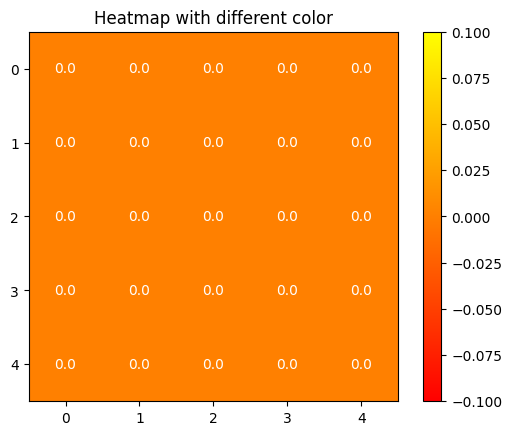

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Heatmap with different color'}>,
 <matplotlib.image.AxesImage at 0x79df694614b0>)

In [ ]:
def plot_Vs(Vs):
  sz = Vs.shape
  fig,ax = plt.subplots(1)
  cax = plt.imshow(Vs, cmap='autumn')

  plt.title("V(s) - Heatmap")

  for i in range(sz[0]):
    for j in range(sz[1]):
        plt.annotate(str(Vs[i,j]), xy=(j, i),
                     ha='center', va='center', color='white')

  fig.colorbar(cax)
  plt.show()

  return fig, ax, cax

plot_Vs(Vs)

## Implement the Value Iteration algorithm

</br>




<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [ ]:
# # Value Iteration Step - update Vs for a given state:
# def value_step(env, Vs, state, gamma):
#   act_space_sz = len(env.action_space.action_meanings)
#   sums_vec = np.zeros(act_space_sz)


#   for act_id, act in enumerate(env.action_space.action_meanings.keys()):
#     p_vec = rand_policy(state)
#     reward_vec = np.zeros(p_vec.shape) # weighted reward vector of the next states (s_tag's) for the taken action

#     for act_pol_id, act_pol in enumerate(range(len(p_vec))):
#       print(f'Action = {act_pol}')
#       env.reset()
#       env.state = (state)

#       s_tag, r, _, _ = env.step(act_pol)
#       reward_vec[act_pol_id] = p_vec[act_pol_id] * ( r + gamma * Vs[s_tag] )
#       # print(f'r, weighted reward = ({r}, {reward_vec[act_id]} )' )

#     print(f'reward_vec = {reward_vec}')
#     sum = reward_vec.sum()
#     # print(sum)

#     sums_vec[act_id] = sum
#     print(f'sums_vec = {sums_vec}')

#   best_act = np.argmax(sums_vec)
#   Vs[state] = sums_vec[best_act]
#   # print(Vs[state])
#   return best_act


In [ ]:
# Value Iteration Step - update V(s) for a given state s:
def value_step(env, Vs, state, gamma):
  act_space_sz = len(env.action_space.action_meanings)
  sums_vec = np.zeros(act_space_sz)


  for act_id, act in enumerate(env.action_space.action_meanings.keys()):
    p_vec = rand_policy(state)
    reward_vec = np.zeros(p_vec.shape) # weighted reward vector of the next states (s_tag's) for the taken action


    # print(f'Action = {act_pol}')
    env.reset()
    env.state = (state)

    s_tag, r, _, _ = env.step(act)
    reward_vec[act_id] = 1 * ( r + gamma * Vs[s_tag] )  # once the action is fixed,
    # the probability of transition for this action is just 1 ,
    # and the probability for the other transitions are zero

    sum = reward_vec.sum()
    sums_vec[act_id] = sum


    # print(f'r, weighted reward = ({r}, {reward_vec[act_id]} )' )
    # print(f'reward_vec = {reward_vec}')
    # print(sum)
    # print(f'sums_vec = {sums_vec}')

  best_act = np.argmax(sums_vec)
  Vs[state] = sums_vec[best_act]
  # print(Vs[state])
  return best_act


In [ ]:
delta = 1
tol = 1e-7
gamma = 1
counter = 0
Vs = reset_Vs(size)

env.reset()

opt_policy = np.zeros_like(Vs)

while delta > tol:
  counter +=1
  delta = 0

  for i,j in np.ndindex(Vs.shape):
    state = (i,j)
    # print(state)
    Vs_old = Vs[state]
    opt_policy[state] = value_step(env=env, Vs=Vs, state=state, gamma=gamma)
    Vs_new = Vs[state]
    delta = np.max([np.abs( Vs_old - Vs_new ), delta])
    # print(f'{delta:.10f}')

  if counter > 200:  # force stop after ___ iterations
    delta = 0

print('Done')

reward_vec = [-1.  0.  0.  0.]
sums_vec = [-1.  0.  0.  0.]
reward_vec = [ 0. -1.  0.  0.]
sums_vec = [-1. -1.  0.  0.]
reward_vec = [ 0.  0. -1.  0.]
sums_vec = [-1. -1. -1.  0.]
reward_vec = [ 0.  0.  0. -1.]
sums_vec = [-1. -1. -1. -1.]
1.0000000000
reward_vec = [-1.  0.  0.  0.]
sums_vec = [-1.  0.  0.  0.]
reward_vec = [ 0. -1.  0.  0.]
sums_vec = [-1. -1.  0.  0.]
reward_vec = [ 0.  0. -1.  0.]
sums_vec = [-1. -1. -1.  0.]
reward_vec = [ 0.  0.  0. -2.]
sums_vec = [-1. -1. -1. -2.]
1.0000000000
reward_vec = [-1.  0.  0.  0.]
sums_vec = [-1.  0.  0.  0.]
reward_vec = [ 0. -1.  0.  0.]
sums_vec = [-1. -1.  0.  0.]
reward_vec = [ 0.  0. -1.  0.]
sums_vec = [-1. -1. -1.  0.]
reward_vec = [ 0.  0.  0. -2.]
sums_vec = [-1. -1. -1. -2.]
1.0000000000
reward_vec = [-1.  0.  0.  0.]
sums_vec = [-1.  0.  0.  0.]
reward_vec = [ 0. -1.  0.  0.]
sums_vec = [-1. -1.  0.  0.]
reward_vec = [ 0.  0. -1.  0.]
sums_vec = [-1. -1. -1.  0.]
reward_vec = [ 0.  0.  0. -2.]
sums_vec = [-1. -1. -1. -2.]
1

## Show results

#### Show resulting value table $V(s)$

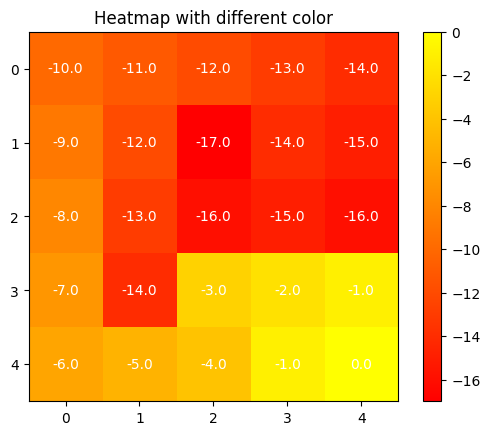

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Heatmap with different color'}>,
 <matplotlib.image.AxesImage at 0x79df0fc5e470>)

In [ ]:
plot_Vs(Vs)

#### Show resulting policy $\pi(\cdot|s)$

↑
→
↓
↔


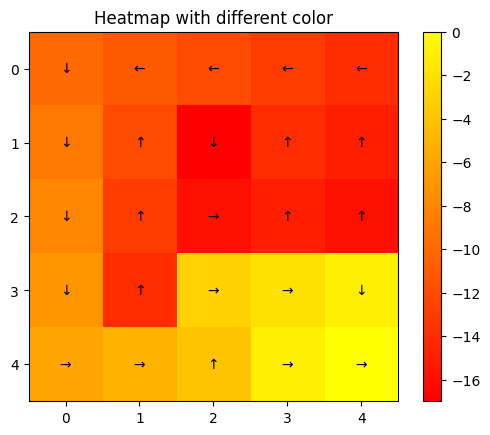

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Heatmap with different color'}>,
 <matplotlib.image.AxesImage at 0x79df0fb0b160>)

In [ ]:
uni1 = u'\u2191'
uni2 = u'\u2192'
uni3 = u'\u2193'
uni4 = u'\u2190'

def assign_unicode(policy, state):
  if policy[state] == 0:
    return uni1
  elif policy[state] == 1:
    return uni2
  elif policy[state] == 2:
    return uni3
  elif policy[state] == 3:
    return uni4
  else:
    raise(ValueError)

# z = lambda a : a + 10
# cond = lambda z : uni1 if z=0 elif

def plot_policy(Vs):
  sz = Vs.shape
  fig,ax = plt.subplots(1)
  cax = plt.imshow(Vs, cmap='autumn')

  plt.title("Optimal Policy")

  for i in range(sz[0]):
    for j in range(sz[1]):
      state = (i,j)
      z = opt_policy[state]
      plt.annotate(assign_unicode(opt_policy, state), xy=(j, i),
                     ha='center', va='center', color='black')

  fig.colorbar(cax)
  plt.show()

  return fig, ax, cax

plot_policy(Vs)



#### Test the resulting agent

In [ ]:
env.reset()
terminated = False
while not terminated:

  opt_act = opt_policy[env.state]
  env.step()

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 4: Dynamic Programming](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)